# Setup

Move this file to the same folder as other .pkl files first.

In [4]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon,shapiro,ttest_rel
import statistics


In [5]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [6]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

# lqg_file = open("LQG_SIM.pkl", "rb") #remember to close afterwards
# LQG_SIM = pickle.load(lqg_file)
# lqg_file.close()

delta_file = open("AvgDelta.pkl", "rb") #remember to close afterwards
avgdelta = pickle.load(delta_file)
delta_file.close()

In [7]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real
  
M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

C:\Users\apfis\AppData\Local\Temp\ipykernel_444\76335962.py:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
C:\Users\apfis\AppData\Local\Temp\ipykernel_444\76335962.py:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


In [8]:
def MSETIME(last_trial):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """

    #(1) MSE time: for every trial for every participant (1 number for each trial)
    MSEt = {}
    for p in range(participants_num): # number of participants = 15
        MSEt['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            r = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][-last_trial[c]:])
            y = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][-last_trial[c]:])
            MSEt['subject'+str(p)]['condition'+str(c)] = np.sum((r-y)**2,axis=1) #time domain error of each trial of each participant

    MSEtvalues = [] # 7 conditions x (15participants * i trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues.append(values_)

    MSEtvalues5 = [] # 7 conditions x (15participants * i trials)
    for c in range(5):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEt['subject'+str(p)]['condition'+str(c)],MSEt['subject'+str(p)]['condition'+str(5)]])))
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEt['subject'+str(p)]['condition'+str(c)],MSEt['subject'+str(p)]['condition'+str(6)]])))
            else:
                values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues5.append(values_)

    return MSEtvalues,MSEtvalues5 #average MSE over all trials for every participant

In [9]:
def MSEFREQ(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(R_Y[-last_trial[c]:][:,stimulated_index[first_freq]]))**2 ,axis=1) 
            #normalize by freq^2
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    MSEfvalues5 = [] # 5 conditions x (15participants * i/2 trials)
    for c in range(num_cond-2):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(5)]])) )
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(6)]])) )
            else:
                values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues5.append(values_)

    return MSEfvalues,MSEfvalues5 #average MSE over all trials for every participant

In [10]:
last_trial = [4,4,4,4,4,4,4]
first_freq = [0,1,2,3,4,5,6,7] # what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])

MSEtvalues,MSEtvalues5 = MSETIME(last_trial)
MSEfvalues,MSEfvalues5= MSEFREQ(last_trial,first_freq)

MSEtvalues_ = [MSEtvalues[5],MSEtvalues[3],MSEtvalues[2],MSEtvalues[4],MSEtvalues[6]] #reorder the conditions
MSEfvalues_ = [MSEfvalues[5],MSEfvalues[3],MSEfvalues[2],MSEfvalues[4],MSEfvalues[6]]

# example code 

## example for single plot

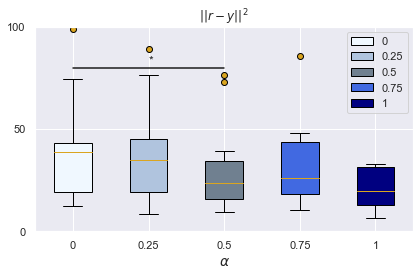

In [271]:
labels = ['0','0.25','0.5','0.75','1'] #slider : EMG
boxcolors = ['aliceblue', 'lightsteelblue','slategrey','royalblue', 'navy']
datas = MSEtvalues_
yticks = [0.,50,100]

bplot = plt.boxplot(datas, widths = 0.5,patch_artist=True,labels=labels, showfliers=True)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set(color = 'goldenrod', linewidth = 1)
for flier in bplot['fliers']:
        flier.set(markerfacecolor = 'goldenrod')
plt.xlabel(r'$\alpha$',fontsize = 14) #add x axis labels
plt.ylim(0,100) # set y axis limit
plt.yticks(yticks) #set y axis ticks
plt.title(r'$||r-y||^2$')
plt.tight_layout()
plt.legend(bplot['boxes'], labels)
locs= [1, 3] ##statistical significance between 0 and 0.5 on x axis
y = [80, 80] ##how high the stat. sig. bar will be
plt.plot(locs, y, "k-")
plt.text(2, 82, "*")
plt.show()

## example for subplots

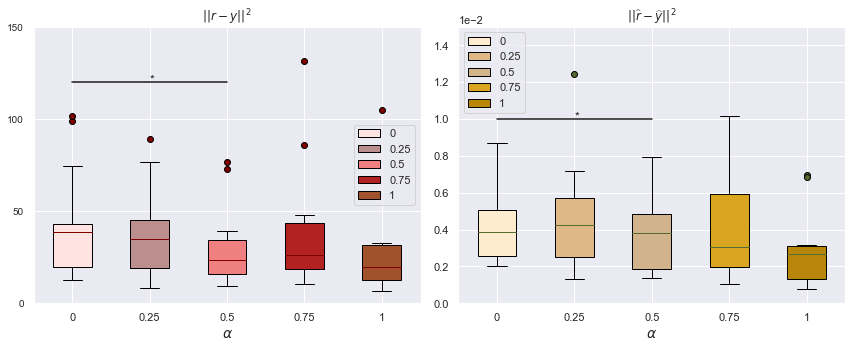

In [272]:
labels = ['0','0.25','0.5','0.75','1'] #slider : EMG
boxcolors = ['mistyrose','rosybrown','lightcoral','firebrick', 'sienna', 'blanchedalmond', 'burlywood','tan','goldenrod', 'darkgoldenrod']
datas = [MSEtvalues_,MSEfvalues_]
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$']
ylimits = [(0,100),(0,0.015)]
yticks0 = [0.,50,100,150]
yticklabels0 = ['0','50','100','150']
yticks = [0.,0.5,1.0,1.5]
yticklabels = ['0.0','0.5','1.0','1.5']
xlabels = ['(a)','(b)','(c)','(d)','(e)',]

fig,axs = plt.subplots(1,2,figsize=(12,5)) 
for j in [0,1]: #for loop for each subplot
    ax = axs[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels, showfliers=True)
    ax.set_xlabel(r'$\alpha$',fontsize = 14) #add x axis labels
    # ax.set_ylabel(titles[j],fontsize = 14) #add y axis labels
    ax.set_ylim(ylimits[j]) #set a limit for y axis
    
    if j == 0:
        ax.set_yticks(yticks0)
        ax.set_yticklabels(yticklabels0, fontsize=10)
        for patch, color in zip(bplot['boxes'], boxcolors[0:5]): # fill with colors
            patch.set_facecolor(color)
        for median in bplot['medians']:
            median.set(color = 'maroon', linewidth = 1)
        for flier in bplot['fliers']:
            flier.set(markerfacecolor = 'maroon')
        ax.plot([1,3], [120, 120], "k-")
        ax.text(2, 120, "*")
    else:  #when j == 1
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4)) #scientific ticks
        for patch, color in zip(bplot['boxes'], boxcolors[5:10]): # fill with colors
            patch.set_facecolor(color)
        for median in bplot['medians']:
            median.set(color = 'darkolivegreen', linewidth = 1)
        for flier in bplot['fliers']:
            flier.set(markerfacecolor = 'darkolivegreen')
        ax.plot([1,3], [0.01, 0.01], "k-")
        ax.text(2, 0.01, "*")
    ax.title.set_text(titles[j]) #set subplot title
    ax.legend(bplot['boxes'], labels)
plt.tight_layout()
plt.show()

Recreating the Graphs with Seaborn

Text(1, 82, '*')

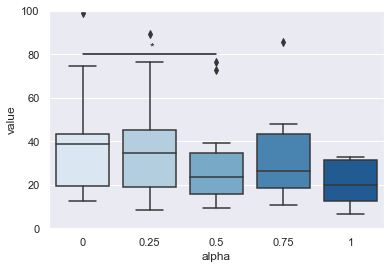

In [275]:
import seaborn as sns
import pandas as pd #seaborn apparently works best with pandas

labels = ['0','0.25','0.5','0.75','1'] #slider : EMG
datas = MSEtvalues_

#convert datas to pandas
data = pd.DataFrame(datas)
df = data.assign(alpha=labels)
mdf = pd.melt(df, id_vars=['alpha'], var_name=['subject'])
ax = sns.boxplot(y="value", x="alpha", data=mdf, palette="Blues")
ax.set_ylim([0, 100])
locs= [0, 2] ##statistical significance between 0 and 0.5 on x axis
y = [80, 80] ##how high the stat. sig. bar will be
plt.plot(locs, y, "k-")
plt.text(1, 82, "*")

Add seaborn boxplots for the subplots

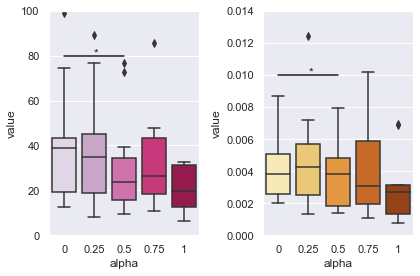

In [281]:
f, axes = plt.subplots(1, 2)
datas = [MSEtvalues_,MSEfvalues_]

#first subplot
data1 = pd.DataFrame(datas[0])
df = data1.assign(alpha=labels)
mdf = pd.melt(df, id_vars=['alpha'], var_name=['subject'])
sns.boxplot(y="value", x="alpha", data=mdf, ax=axes[0], palette="PuRd")
axes[0].set_ylim([0, 100])
axes[0].plot([0,2], [80, 80], "k-")
axes[0].text(1, 80, "*")
#second subplot
data1 = pd.DataFrame(datas[1])
df = data1.assign(alpha=labels)
mdf = pd.melt(df, id_vars=['alpha'], var_name=['subject'])
sns.boxplot(y="value", x="alpha", data=mdf, ax=axes[1], palette="YlOrBr")
axes[1].set_ylim([0, 1.4e-2])
axes[1].plot([0,2], [0.01, 0.01], "k-")
axes[1].text(1, 0.01, "*")
plt.tight_layout()
plt.show()